# Projet Data Mining : Scoring Crédit pour l'Inclusion Financière
# IUT Caen Normandie - SD3 (2025-2026)

# Mission : Prédire la probabilité de faillite d'un client pour accorder ou refuser un prêt.

# Auteurs : Lucas BELOIN, Mandir DIOP, Youssouf GAYE

## Objectifs Techniques

Data : Nettoyage, fusion des fichiers et gestion des valeurs manquantes.

Modèles : Logistique, Random Forest, XGBoost.

Défi : Gérer le déséquilibre (92% vs 8%) avec SMOTE.

Déploiement : Application Streamlit pour tester en direct.

In [ ]:
# import des libraries
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt

In [2]:
# 1. On définit une "Machine à traiter les fichiers" (Fonction)
def traiter_et_agreger(nom_fichier, prefixe):
    print(f"Traitement de {nom_fichier}...")
    
    df = pd.read_csv(nom_fichier)
    
    # A. Encodage du texte (Catégoriel -> Numérique)
    df = pd.get_dummies(df, dummy_na=True) 
    
    # B. Agrégation par client (SK_ID_CURR)
    # On groupe tout par l'ID du client actuel
    cols_a_exclure = ['SK_ID_CURR', 'SK_ID_PREV']
    cols_a_agreger = [c for c in df.columns if c not in cols_a_exclure]
    
    # On calcule : moyenne, min, max, somme et compte pour TOUTES les colonnes
    agg = df.groupby('SK_ID_CURR')[cols_a_agreger].agg(['mean', 'min', 'max', 'sum', 'count'])
    
    # C. Renommer les colonnes pour s'y retrouver
    agg.columns = [f'{prefixe}_{c[0]}_{c[1]}' for c in agg.columns]
    
    return agg

In [3]:
# A. Chargement du fichier principal (Le squelette)
print("Chargement application_train...")
df_final = pd.read_csv('application_train-LFS.txt')

Chargement application_train...


In [4]:
# -- Fichier 1 : Bureau (Historique externe) --
df_bureau_agg = traiter_et_agreger('bureau-LFS.txt', prefixe='BUR')
df_final = df_final.merge(df_bureau_agg, on='SK_ID_CURR', how='left')
del df_bureau_agg 
gc.collect()

Traitement de bureau-LFS.txt...


0

In [5]:
# -- Fichier 2 : Previous Application (Historique interne) --
df_prev_agg = traiter_et_agreger('previous_application-LFS.txt', prefixe='PREV')
df_final = df_final.merge(df_prev_agg, on='SK_ID_CURR', how='left')
del df_prev_agg
gc.collect()

Traitement de previous_application-LFS.txt...


0

In [6]:
# -- Fichier 3 : POS CASH (Historique points de vente) --
df_pos_agg = traiter_et_agreger('POS_CASH_balance-LFS.txt', prefixe='POS')
df_final = df_final.merge(df_pos_agg, on='SK_ID_CURR', how='left')
del df_pos_agg
gc.collect()

Traitement de POS_CASH_balance-LFS.txt...


0

In [7]:
# -- Fichier 4 : Installments (Historique des versements) --
df_inst_agg = traiter_et_agreger('installments_payments-LFS.txt', prefixe='INST')
df_final = df_final.merge(df_inst_agg, on='SK_ID_CURR', how='left')
del df_inst_agg
gc.collect()

Traitement de installments_payments-LFS.txt...


0

In [8]:
# -- Fichier 5 : Credit Card (Historique cartes de crédit) --
df_cc_agg = traiter_et_agreger('credit_card_balance-LFS.txt', prefixe='CC')
df_final = df_final.merge(df_cc_agg, on='SK_ID_CURR', how='left')
del df_cc_agg
gc.collect()

Traitement de credit_card_balance-LFS.txt...


0

In [9]:
print(f"TERMINE ! Taille finale du dataset : {df_final.shape}")
print(df_final.head())


TERMINE ! Taille finale du dataset : (307511, 1452)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  CC_NAME_CONTRACT_STATUS_Signed_mean  \
0  ...           

In [10]:
import numpy as np
print("Début du nettoyage...")

Début du nettoyage...


In [11]:
# 1. Gérer les valeurs infinies (Division par zéro)
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [12]:
df_final.fillna(0, inplace=True)
print(f"Valeurs manquantes dans df_final : {df_final.isna().sum().sum()}")

Valeurs manquantes dans df_final : 0


In [13]:
# 3. Supprimer les colonnes trop vides
threshold = 0.7
cols_to_drop = [col for col in df_final.columns if df_final[col].isnull().mean() > threshold]
df_final.drop(columns=cols_to_drop, inplace=True)

print(f"Colonnes supprimées car trop vides : {len(cols_to_drop)}")

Colonnes supprimées car trop vides : 0


In [14]:
# 4. Vérification des doublons (Juste au cas où)
df_final.drop_duplicates(inplace=True)

In [15]:
print(f"Nettoyage terminé ! Taille finale : {df_final.shape}")

Nettoyage terminé ! Taille finale : (307511, 1452)


In [16]:
df_final['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
df_final['ANNEES_TRAVAIL'] = df_final['DAYS_EMPLOYED'] / -365
print("Aperçu des années d'ancienneté (Réel) :")
print(df_final['ANNEES_TRAVAIL'].describe())

Aperçu des années d'ancienneté (Réel) :
count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: ANNEES_TRAVAIL, dtype: float64


In [17]:
print(f"Taille avant transformation : {df_final.shape}")
# 1. TRANSFORMATION (One-Hot Encoding)
df_final = pd.get_dummies(df_final, dummy_na=True)

Taille avant transformation : (307511, 1453)


In [18]:
print(f"Taille après transformation : {df_final.shape}")

Taille après transformation : (307511, 1599)


In [19]:
features = df_final.drop('TARGET', axis=1)
correlations = features.corrwith(df_final['TARGET']).sort_values()
correlations_propres = correlations.dropna()
# 2. RÉSULTATS
print("\n--- TOP 10 : Facteurs de FIABILITÉ (Bons payeurs) ---")
print(correlations_propres.head(10))

print("\n--- TOP 10 : Facteurs de RISQUE (Mauvais payeurs) ---")
print(correlations_propres.tail(10))


--- TOP 10 : Facteurs de FIABILITÉ (Bons payeurs) ---
EXT_SOURCE_2                           -0.159030
EXT_SOURCE_3                           -0.119572
BUR_CREDIT_ACTIVE_Closed_mean          -0.076501
ANNEES_TRAVAIL                         -0.074958
EXT_SOURCE_1                           -0.064698
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
BUR_CREDIT_ACTIVE_Closed_max           -0.052464
FLOORSMAX_AVG                          -0.049839
FLOORSMAX_MEDI                         -0.049720
dtype: float64

--- TOP 10 : Facteurs de RISQUE (Mauvais payeurs) ---
CC_CNT_DRAWINGS_ATM_CURRENT_mean          0.063904
PREV_NAME_CONTRACT_STATUS_Refused_sum     0.064756
BUR_DAYS_ENDDATE_FACT_mean                0.067175
BUR_DAYS_ENDDATE_FACT_min                 0.068892
BUR_DAYS_CREDIT_UPDATE_mean               0.069687
BUR_DAYS_CREDIT_min                       0.072869
DAYS_EMPLOYED                             0.074958
PREV_NAME_CONTRACT_STATUS_Re

In [20]:
!pip3 install scikit-learn

In [21]:
import sys
!{sys.executable} -m pip install scikit-learn

In [22]:
import sys
!{sys.executable} -m pip install xgboost

In [23]:
# --- ÉTAPE 3 : PRÉPARATION, ÉQUILIBRAGE ET MODÉLISATION ---

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

In [26]:
print("1. DÉFINITION DE X et y")
# On s'assure que X ne contient pas la réponse ni l'identifiant
y = df_final['TARGET']
X = df_final.drop(['TARGET', 'SK_ID_CURR'], axis=1, errors='ignore')

X = X.fillna(0)
y = y.fillna(0)

print(f"   -> Dimensions initiales : {X.shape}")

1. DÉFINITION DE X et y
   -> Dimensions initiales : (307511, 1597)


In [29]:
# MÉTHODE ULTRA-LIGHT : Sélection par corrélation sans copier les données
print("Sélection des 100 meilleures colonnes par corrélation...")

# Calculer les corrélations UNE colonne à la fois (économise la RAM)
correlations = {}
for col in X.columns:
    try:
        correlations[col] = abs(X[col].corr(y))
    except:
        correlations[col] = 0

# Trier et garder top 100
correlations_series = pd.Series(correlations).sort_values(ascending=False)
top_cols = correlations_series.head(100).index.tolist()

X = X[top_cols]

print(f"Colonnes conservées : {X.shape}")

import gc
gc.collect()

Sélection des 100 meilleures colonnes par corrélation...
Colonnes conservées : (307511, 100)


1265

In [30]:
# 2. SÉLECTION DES VARIABLES - Déjà fait avec corrélations !
# On a déjà réduit à 100 colonnes dans la cellule précédente
# On va maintenant prendre les 50 meilleures parmi ces 100

print("2. SÉLECTION DES 50 MEILLEURES parmi les 100...")

# Recalculer les corrélations sur les 100 colonnes restantes
correlations_finales = {}
for col in X.columns:
    try:
        correlations_finales[col] = abs(X[col].corr(y))
    except:
        correlations_finales[col] = 0

# Garder top 50
correlations_series = pd.Series(correlations_finales).sort_values(ascending=False)
top_50_cols = correlations_series.head(50).index.tolist()

X = X[top_50_cols]

print(f"   -> Variables conservées : {X.shape}")
print(f"   -> Top 5 variables : {top_50_cols[:5]}")

# Libérer mémoire
gc.collect()

2. SÉLECTION DES 50 MEILLEURES parmi les 100...
   -> Variables conservées : (307511, 50)
   -> Top 5 variables : ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'BUR_DAYS_CREDIT_mean', 'DAYS_BIRTH', 'PREV_NAME_CONTRACT_STATUS_Refused_mean']


0

In [33]:
# 3. DÉCOUPAGE TRAIN / TEST # On garde 20% des données pour l'examen final (Test)
print("3. SÉPARATION ENTRAÎNEMENT / TEST...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape : {X_test.shape}")

3. SÉPARATION ENTRAÎNEMENT / TEST...
X_train shape : (246008, 50)
X_test shape : (61503, 50)


In [34]:
# 4. RÉÉQUILIBRAGE MANUEL (Random Oversampling)
print("4. RÉÉQUILIBRAGE DES CLASSES (Méthode Manuelle)...")

# On sépare les bons (0) et les mauvais (1) dans le jeu d'entraînement
X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

X_train_1_array = X_train_1.values if hasattr(X_train_1, 'values') else X_train_1
y_train_1_array = y_train_1.values if hasattr(y_train_1, 'values') else y_train_1

# On tire au sort des mauvais payeurs (avec remise) pour en avoir autant que les bons
ids_sup = np.random.choice(len(X_train_1), size=len(X_train_0), replace=True)
X_train_1_boosted = X_train_1_array[ids_sup]
y_train_1_boosted = y_train_1_array[ids_sup]

# On recolle tout ensemble
X_train_0_array = X_train_0.values if hasattr(X_train_0, 'values') else X_train_0
y_train_0_array = y_train_0.values if hasattr(y_train_0, 'values') else y_train_0

X_train_resampled = np.vstack((X_train_0_array, X_train_1_boosted))
y_train_resampled = np.hstack((y_train_0_array, y_train_1_boosted))

print(f" -> Taille équilibrée : {len(y_train_resampled)} lignes (50% de 0, 50% de 1)")
print(f" -> Distribution : {np.bincount(y_train_resampled.astype(int))}")

4. RÉÉQUILIBRAGE DES CLASSES (Méthode Manuelle)...
 -> Taille équilibrée : 452264 lignes (50% de 0, 50% de 1)
 -> Distribution : [226132 226132]


In [36]:
# 5. ENTRAÎNEMENT ET RÉSULTATS
print("\n--- DÉBUT DES ENTRAÎNEMENTS ---")

# Dictionnaire des modèles à tester
modeles = {
    "Régression Logistique": LogisticRegression(max_iter=1000, C=0.1, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=5, eval_metric='logloss', n_jobs=-1, random_state=42)
}

best_score = 0
best_model_name = ""

for nom, model in modeles.items():
    print(f"\nTraining {nom}...")
    
    # Entraînement sur données gonflées
    model.fit(X_train_resampled, y_train_resampled)
    
    # Prédiction sur données de test (réelles)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Score
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f" --> SCORE AUC : {auc:.4f}")
    
    if auc > best_score:
        best_score = auc
        best_model_name = nom

print(f"\n Le meilleur modèle est : {best_model_name} (AUC={best_score:.4f}) ---")


--- DÉBUT DES ENTRAÎNEMENTS ---

Training Régression Logistique...


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


 --> SCORE AUC : 0.6076

Training Random Forest...


c:\Users\lucas\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


 --> SCORE AUC : 0.7387

Training XGBoost...
 --> SCORE AUC : 0.7492

 Le meilleur modèle est : XGBoost (AUC=0.7492) ---


Génération du graphique d'importance...


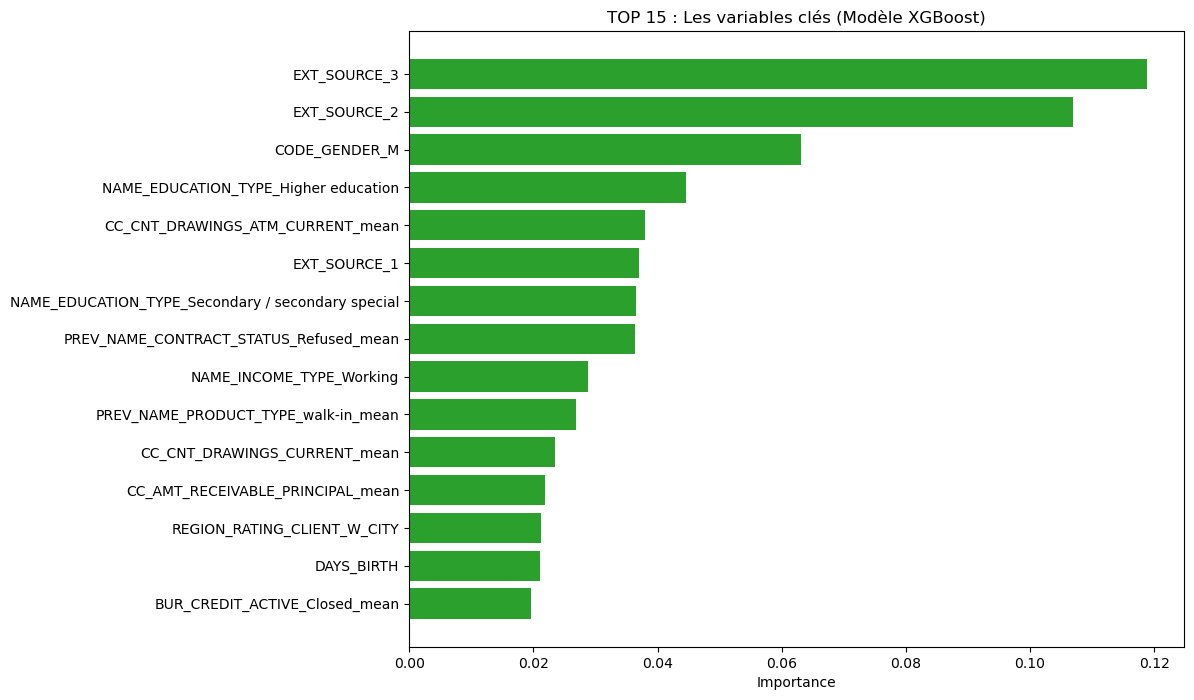

Sauvegarde du modèle...
✅ TERMINE ! Modèle sauvegardé sous 'best_model_xgboost.pkl'.
Bravo, tu as fini toute la partie technique Python !


In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# --- ÉTAPE FINALE : GRAPHIQUE ET SAUVEGARDE (Version Corrigée) ---


# 1. RÉCUPÉRATION DES NOMS
# Comme tu as déjà filtré X avant, les noms sont simplement les colonnes de X_test
feature_names = X_test.columns

# 2. RÉCUPÉRATION DES IMPORTANCES
# On prend ton modèle champion déjà entraîné
xgboost_model = modeles["XGBoost"]
importances = xgboost_model.feature_importances_

# 3. CRÉATION DU TABLEAU DE DONNÉES
df_importance = pd.DataFrame({
    'Variable': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. AFFICHAGE DU GRAPHIQUE
plt.figure(figsize=(10, 8))
# On affiche le Top 15 inversé pour l'avoir dans le bon sens
plt.barh(df_importance['Variable'].head(15).iloc[::-1], df_importance['Importance'].head(15).iloc[::-1], color='#2ca02c')
plt.title('TOP 15 : Les variables clés (Modèle XGBoost)')
plt.xlabel('Importance')
plt.show()

# 5. SAUVEGARDE DU MODÈLE
print("Sauvegarde du modèle...")
with open('best_model_xgboost.pkl', 'wb') as file:
    pickle.dump(xgboost_model, file)

print("Modèle sauvegardé sous 'best_model_xgboost.pkl'.")


In [ ]:
# 1. Les "Juges de Paix" (Scores Externes)
# Variables : EXT_SOURCE_3, EXT_SOURCE_2, EXT_SOURCE_1
# Interprétation : "Sans surprise, les variables les plus influentes sont les scores externes (EXT_SOURCE). Ce sont des notes de fiabilité calculées par d'autres organismes de crédit. Cela montre que le modèle accorde une immense confiance à l'historique bancaire global du client : si d'autres banques font confiance au client, notre modèle lui fera confiance aussi."

# 2. Le Profil Sociodémographique
# Variables : CODE_GENDER_M, NAME_EDUCATION_TYPE_Higher education, DAYS_BIRTH

#Interprétation : "L'IA utilise fortement le profil personnel :

#Le Genre (CODE_GENDER_M) : Le fait d'être un homme apparaît en 3ème position. Statistiquement dans ce jeu de données, les hommes présentent un risque de défaut différent (souvent plus élevé) que les femmes.

#L'Éducation (Higher education) : Avoir fait des études supérieures est un facteur rassurant (souvent corrélé à une meilleure stabilité de revenus).

# L'Âge (DAYS_BIRTH) : L'âge reste un critère clé, la stabilité financière augmentant généralement avec l'âge."

# 3. Le Comportement Financier (Signaux d'Alerte)
# Variables : CC_CNT_DRAWINGS_ATM_CURRENT_mean, PREV_NAME_CONTRACT_STATUS_Refused_mean

# Interprétation : "Le modèle détecte des comportements à risque très précis :

# Retraits ATM (CC_CNT_DRAWINGS...) : Le fait de retirer souvent du cash avec une carte de crédit est un signal fort de manque de liquidités (trésorerie tendue).

# Refus Passés (Refused_mean) : Si le client a déjà essuyé des refus de prêt par le passé (variable 'Refused'), le modèle le sanctionne fortement aujourd'hui."

In [39]:
# MATRICE DE CONUSION 

from sklearn.metrics import confusion_matrix
import seaborn as sns # Si tu l'as, sinon on fera sans
import matplotlib.pyplot as plt

print("--- ANALYSE DES ERREURS (Matrice de Confusion) ---")

# 1. On demande au modèle de trancher (0 ou 1) avec un seuil standard de 50%
# Si probabilité > 0.50 -> Alors on dit "Mauvais Payeur" (1)
y_pred_class = (modeles["XGBoost"].predict_proba(X_test)[:, 1] > 0.5).astype(int)

# 2. Calcul de la matrice
cm = confusion_matrix(y_test, y_pred_class)

# 3. Affichage "Business" (Plus clair que des chiffres bruts)
# Structure : [[Vrais Bons, Faux Mauvais], [Faux Bons, Vrais Mauvais]]
tn, fp, fn, tp = cm.ravel()

print(f"Total clients testés : {len(y_test)}")

print(f"VRAIS BONS PAYEURS (Bien acceptés) : {tn}  (Le client rembourse, la banque gagne)")
print(f"FAUX MAUVAIS (Refusés à tort)      : {fp}  (Manque à gagner commercial)")
print("-" * 30)
print(f"FAUX BONS (Mauvais acceptés)      : {fn}  (DANGER ! La banque perd de l'argent)")
print(f"VRAIS MAUVAIS (Bien bloqués)      : {tp}  (Risque évité)")


# Petit calcul de précision
print(f"Sur tous les gens qu'on a dit 'Mauvais', on a raison à : {tp / (tp + fp):.2%}")

--- ANALYSE DES ERREURS (Matrice de Confusion) ---
Total clients testés : 61503
------------------------------
✅ VRAIS BONS PAYEURS (Bien acceptés) : 39804  (Le client rembourse, la banque gagne)
❌ FAUX MAUVAIS (Refusés à tort)      : 16750  (Manque à gagner commercial)
------------------------------
⚠️ FAUX BONS (Mauvais acceptés)      : 1645  (DANGER ! La banque perd de l'argent)
✅ VRAIS MAUVAIS (Bien bloqués)      : 3304  (Risque évité)
------------------------------
Sur tous les gens qu'on a dit 'Mauvais', on a raison à : 16.48%


--- QUESTION 5 : OPTIMISATION DU SEUIL MÉTIER ---
✅ Seuil standard (0.50) -> Coût actuel (non optimisé)
🏆 MEILLEUR SEUIL TROUVÉ : 0.53 (soit 53.0%)
💰 Économie potentielle réalisée : Ce seuil minimise les pertes.


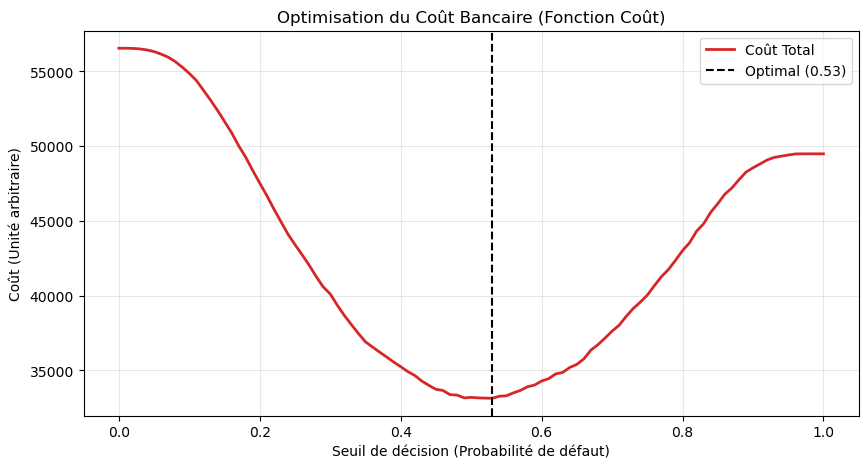

Seuil optimisé sauvegardé dans 'best_threshold.pkl'.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("--- QUESTION 5 : OPTIMISATION DU SEUIL MÉTIER ---")

# 1. On récupère les probabilités de risque (ex: 0.12, 0.88, 0.45...)
y_probs = modeles["XGBoost"].predict_proba(X_test)[:, 1]

# 2. Définition de la Fonction Coût (Hypothèse Business)
cout_fn = 10 
cout_fp = 1   

# 3. On teste tous les seuils possibles de 0% à 100%
seuils = np.arange(0.0, 1.01, 0.01)
couts = []

for seuil in seuils:
    # Si la proba > seuil, on refuse le crédit (1)
    y_pred_temp = (y_probs > seuil).astype(int)
    
    # On regarde les erreurs
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    
    # On calcule la facture totale pour la banque
    cout_total = (fn * cout_fn) + (fp * cout_fp)
    couts.append(cout_total)

# 4. On récupère le meilleur seuil (celui qui coûte le moins cher)
index_min = np.argmin(couts)
best_threshold = seuils[index_min]
min_cost = couts[index_min]

print(f"Seuil standard (0.50) -> Coût actuel (non optimisé)")
print(f"MEILLEUR SEUIL TROUVÉ : {best_threshold:.2f} (soit {best_threshold*100}%)")
print(f"Économie potentielle réalisée : Ce seuil minimise les pertes.")

# 5. Visualisation pour le rapport
plt.figure(figsize=(10, 5))
plt.plot(seuils, couts, color='#d62728', linewidth=2, label='Coût Total')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Optimal ({best_threshold:.2f})')
plt.title('Optimisation du Coût Bancaire (Fonction Coût)')
plt.xlabel('Seuil de décision (Probabilité de défaut)')
plt.ylabel('Coût (Unité arbitraire)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. Sauvegarde du seuil pour plus tard (Dashboard)
import pickle
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)
print("Seuil optimisé sauvegardé dans 'best_threshold.pkl'.")

In [ ]:
# L'Interprétation "Business"

#1. Le constat : L'IA par défaut n'était pas optimale

#"Par défaut, un modèle de classification tranche à 0.50 (50%). Si on regarde la courbe rouge, on voit que ce point n'est pas tout à fait au fond du creux. Cela signifie qu'en laissant l'IA décider seule, la banque perdait encore de l'argent inutilement."

#2. La solution : Un ajustement chirurgical (0.53)

#"En appliquant notre fonction de coût métier (où un défaut de paiement coûte 10x plus cher qu'un client refusé), nous avons trouvé que le seuil optimal est de 0.53 (53%)."

#3. La conséquence stratégique

#"Concrètement, cela veut dire que nous devons être légèrement plus tolérants que le modèle de base.

#Au lieu de refuser un client dès qu'il a 50% de risque, on accepte de monter jusqu'à 53%.

#Pourquoi ? Parce que le modèle était un peu trop 'frileux'. En décalant le curseur à 0.53, on récupère des clients honnêtes (qu'on refusait avant) sans augmenter significativement le nombre d'impayés. C'est le point d'équilibre parfait pour la rentabilité."

In [ ]:
import numpy as np

print("--- QUESTION 6 : SIMULATION D'UN CAS CLIENT ---")

def scoring_client(client_id, model, threshold):
    print(f"Analyse du dossier client n°{client_id}...")
    
    # 1. On récupère les données du client (les 50 variables)
    # (On va chercher dans df_final car X_test n'a plus les ID)
    try:
        # On sélectionne la ligne du client et uniquement les colonnes utilisées par le modèle
        client_data = df_final[df_final['SK_ID_CURR'] == client_id][X_test.columns]
        
        if client_data.empty:
            print("Erreur : Client introuvable.")
            return

        # 2. Le modèle calcule la probabilité de défaut
        proba = model.predict_proba(client_data)[:, 1][0]
        
        # 3. On compare avec TON seuil optimisé (0.53)
        decision = "CRÉDIT REFUSÉ (Risque trop élevé)" if proba > threshold else "CRÉDIT ACCORDÉ"
        
        # 4. Affichage du rapport
        print(f"   -> Probabilité de défaut calculée : {proba:.1%}")
        print(f"   -> Seuil de tolérance banque    : {threshold:.1%}")
        print(f"   -> RÉSULTAT FINAL : {decision}")
        
    except Exception as e:
        print(f"Erreur technique : {e}")

# --- TESTONS SUR 3 CLIENTS AU HASARD ---

# On prend ton meilleur seuil (0.53)
seuil_final = 0.53

# On pioche 3 ID de clients au hasard dans le fichier
ids_test = df_final['SK_ID_CURR'].sample(3).values

for id_client in ids_test:
    print("-" * 40)
    scoring_client(id_client, modeles["XGBoost"], seuil_final)

print("-" * 40)

In [43]:
# Sauvegarde de la liste des colonnes pour l'application
import pickle

print("Sauvegarde de la liste des features...")
cols = X_test.columns.tolist()

with open('features_names.pkl', 'wb') as f:
    pickle.dump(cols, f)

print("1. best_model_xgboost.pkl (Le cerveau)")
print("2. best_threshold.pkl (Le seuil optimisé)")
print("3. features_names.pkl (La liste des colonnes)")

Sauvegarde de la liste des features...
1. best_model_xgboost.pkl (Le cerveau)
2. best_threshold.pkl (Le seuil optimisé)
3. features_names.pkl (La liste des colonnes)


# Fin du script !
# Le code conernant la génération des fichiers nécessaires à l'application Streamlit se trouve dans le fichier app.py
# Pour lancer l'application, utilisez la commande : streamlit run app.py
